<a href="https://colab.research.google.com/github/ariesslin/ie7500-g1-tweet-sentiment-nlp/blob/main/scripts/3.%20Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>3b. Deep Learning Model – Bidirectional LSTM</strong></h2>
  <p style="color:#333333;">Bidirectional LSTM with Word2Vec embeddings for sequence-aware sentiment analysis.</p>
</div>

## Deep Learning Sentiment Classifier: Bidirectional LSTM with Word2Vec Embeddings

This notebook implements a **deep learning model** for tweet sentiment classification using **Bidirectional LSTM** networks combined with **Word2Vec word embeddings**.

### Why Bidirectional LSTM?

- **Sequential Understanding**: Unlike the TF-IDF baseline, LSTMs can capture the **sequential nature** of language, understanding how words relate to each other in context.
- **Bidirectional Processing**: By processing text both forward and backward, the model gains a more complete understanding of context around each word.
- **Long-term Dependencies**: LSTMs excel at capturing relationships between words that are far apart in a sentence, crucial for understanding sentiment in complex tweets.
- **Contextual Awareness**: Can handle negation, sarcasm, and other linguistic nuances that bag-of-words models miss.

### Why Word2Vec Embeddings?

Instead of sparse TF-IDF vectors, we use **dense Word2Vec embeddings** that capture semantic relationships between words. Words with similar meanings are positioned close to each other in the embedding space, allowing the model to generalize better to unseen vocabulary and understand semantic similarity.

### What This Notebook Covers

- Loads and preprocesses the training and validation datasets
- Trains a custom Word2Vec model on the tweet corpus
- Builds bidirectional LSTM architecture with embedding layers
- Implements proper text tokenization and sequence padding
- Trains the model with early stopping and performance monitoring
- Evaluates performance using accuracy, precision, recall, F1-score, and confusion matrix
- Provides analysis of model strengths and limitations

This LSTM model represents a significant step up in complexity from our logistic regression baseline, designed to capture the nuanced, context-dependent nature of sentiment in social media text.


In [1]:
# Mount Google Drive and Setup Project Environment
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
PROJECT_ROOT = "/content/drive/MyDrive/northeastern/ie7500/ie7500-g1-tweet-sentiment-nlp"

In [3]:
train_path = f"{PROJECT_ROOT}/processed_data/train_dataset.csv"
val_path = f"{PROJECT_ROOT}/processed_data/val_dataset.csv"

In [4]:
import sys
!{sys.executable} -m pip install -r "{PROJECT_ROOT}/requirements.txt"

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.8.0/en_core_web_lg-3.8.0-py3-none-any.whl (400.7 MB)


In [5]:
# Import required libraries for LSTM model development
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gensim for Word2Vec embeddings and text preprocessing
from gensim.models import Word2Vec

# TensorFlow/Keras for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Nadam

# Scikit-learn for evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# Project utilities
sys.path.append(f"{PROJECT_ROOT}/utils")
from helper import load_clean_train_val_datasets

In [6]:
train_df, val_df = load_clean_train_val_datasets(train_path, val_path)

In [7]:
train_df.head()

,text,target
0,doesnt know hahahahahaha hi world twitter,4
1,gahh im hungryy shouldve something teadinner s...,0
2,last day,0
3,sunburn forget put sunblock shnatzi,0
4,usermention want go home contact hurt,0


In [8]:
val_df.head()

,text,target
0,lng fn day mah head killin im tire den bih bt ...,0
1,usermention nah manthat fit lmao run mix oh ma...,4
2,usermention kno right thermostat war almost al...,0
3,usermention awww well dont worry youre miss mu...,0
4,use little girls room soo bad soon leave bos c...,0


### Data Preparation for LSTM Model

For the LSTM model, we need to prepare the data differently than for the logistic regression baseline:

1. **Text Tokenization**: Split preprocessed tweets into token sequences (preprocessing was already done in step 2 notebook)
2. **Word2Vec Training**: Train embeddings on our tokenized corpus to capture semantic relationships
3. **Sequence Conversion**: Transform text into numerical sequences for neural network input
4. **Padding**: Ensure all sequences have the same length for batch processing
5. **Target Encoding**: Convert sentiment labels to binary format (0/1) for sigmoid output

This preparation enables the LSTM to understand both the sequential nature of text and the semantic meaning of individual words. Since the data has already been preprocessed in `2-Data-Preprocessing.ipynb`, we only need to tokenize by splitting on spaces.


#### Text Tokenization

In [9]:
# Extract features and targets, ensuring proper data types
X_train = train_df['text'].astype(str)
y_train = train_df['target'].astype(int).replace({4: 1})  # Remap 4 → 1 for binary classification

X_val = val_df['text'].astype(str)
y_val = val_df['target'].astype(int).replace({4: 1})

# Display data shapes
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("X_train shape:", X_train.shape, "| y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "| y_val shape:", y_val.shape)

Train shape: (1119609, 2)
Validation shape: (239917, 2)
X_train shape: (1119609,) | y_train shape: (1119609,)
X_val shape: (239917,) | y_val shape: (239917,)


In [10]:
# Tokenize tweets by splitting on spaces
# Since preprocessing was done in 2-Data-Preprocessing.ipynb, we just need to split the text
tokenized_train = X_train.apply(lambda x: x.split()).tolist()
tokenized_val = X_val.apply(lambda x: x.split()).tolist()

print(f"Tokenized {len(tokenized_train)} training tweets")
print(f"Tokenized {len(tokenized_val)} validation tweets")
print(f"Sample tokenized tweet: {tokenized_train[0][:10]}...")  # Show first 10 tokens

Tokenized 1119609 training tweets
Tokenized 239917 validation tweets
Sample tokenized tweet: ['doesnt', 'know', 'hahahahahaha', 'hi', 'world', 'twitter']...


#### Word2Vec Embedding Training

Next, we train a Word2Vec model on our tokenized tweet corpus using the `gensim` library. Below is a breakdown of the key parameters used:

- `sentences=tokenized_train`: List of tokenized tweets used to train the embeddings.
- `vector_size=embedding_dim`: Dimensionality of the word vectors).
- `window=10`: Context window size; how many words before/after the target word to consider.
- `min_count=2`: Ignores words that appear fewer than 2 times to reduce noise.
- `sg=1`: Use Skip-Gram (1) instead of CBOW (0). Skip-Gram performs better for smaller datasets and rare words.
- `seed=42`: Ensures reproducibility by fixing random initialization.
- `workers=10`: Number of CPU threads used for training.

After training, we extract the `KeyedVectors` object for efficient similarity lookup and evaluation.


In [11]:
# Train Word2Vec model on our tokenized tweet corpus
embedding_dim = 100  # Dimensionality of word vectors

word2vec_model = Word2Vec(
    sentences=tokenized_train,
    vector_size=embedding_dim,
    window=10,           # Maximum distance between current and predicted word
    min_count=2,         # Ignore words with frequency less than this
    sg=1,                # Use skip-gram algorithm (1) vs CBOW (0)
    seed=42,             # For reproducibility
    workers=10           # Number of threads for training
)

# Extract the KeyedVectors for efficient lookup
word_vectors = word2vec_model.wv

print(f"Word2Vec model trained with {len(word_vectors)} unique words")
print(f"Embedding dimension: {embedding_dim}")
print(f"Sample similar words to 'good': {word_vectors.most_similar('good', topn=5) if 'good' in word_vectors else 'N/A'}")

Word2Vec model trained with 90488 unique words
Embedding dimension: 100
Sample similar words to 'good': [('great', 0.8209981918334961), ('goooooood', 0.7989086508750916), ('lolgood', 0.7928287982940674), ('goooood', 0.783364474773407), ('gooooooood', 0.7828888297080994)]


#### Interpretation of Word2Vec Output

The output shows:
- **Number of unique words**: This is the vocabulary size learned by Word2Vec from the tweet corpus.
- **Embedding dimension**: Confirms the size of each word vector.
- **Top 5 similar words to "good"**: These are the most semantically similar words to "good" in the learned embedding space, along with their cosine similarity scores.

For example, words like `'goooood'`, `'great'`, and `'lolgood'` appear close to `'good'`, indicating that the model has successfully captured semantic relationships between sentiment-rich tokens.


### Keras Tokenizer Setup

We now prepare the data for use in a Keras-compatible deep learning model. While our tweets are already tokenized into lists of words, Keras expects sequences of integers.

Here's what this step does:
- Joins tokens back into space-separated strings (needed for Keras Tokenizer).
- Initializes and fits the Keras Tokenizer to the training texts.
- Limits vocabulary to the size of the trained Word2Vec model to ensure every word has an embedding.

This tokenizer will later convert our text into padded integer sequences that LSTM layers can process.

In [12]:
### Keras Tokenizer Setup

# Join tokens back into space-separated strings for Keras compatibility
tokenized_train_texts = [' '.join(tokens) for tokens in tokenized_train]
tokenized_val_texts = [' '.join(tokens) for tokens in tokenized_val]

# Initialize and fit Keras tokenizer
# Note: We limit vocabulary to match our Word2Vec model to ensure full embedding coverage
tokenizer = Tokenizer(num_words=len(word_vectors) + 1)
tokenizer.fit_on_texts(tokenized_train_texts)

word_index = tokenizer.word_index
print(f"Keras tokenizer vocabulary size: {len(word_index)}")
print(f"Limited to top {tokenizer.num_words} words")

Keras tokenizer vocabulary size: 304331
Limited to top 90489 words


### Embedding Matrix Construction

Next, we build the embedding matrix that maps each tokenizer word index to its corresponding Word2Vec embedding.

- We initialize a zero matrix of shape `(vocab_size, embedding_dim)`.
- For each word in the tokenizer's vocabulary that is also in our Word2Vec model, we copy its vector into the matrix.
- This matrix will be loaded into the Keras Embedding layer with `trainable=False` to freeze pretrained embeddings.
- We also calculate **embedding coverage** — the percentage of tokenizer words that have embeddings. A low score may affect model quality.


In [13]:
### Building the Embedding Matrix

# Create embedding matrix that maps tokenizer indices to Word2Vec vectors
embedding_matrix = np.zeros((tokenizer.num_words, embedding_dim))

words_found = 0
for word, i in word_index.items():
    if i >= tokenizer.num_words:
        continue
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]
        words_found += 1

coverage = words_found / tokenizer.num_words
print(f"Words matched in Word2Vec: {words_found}/{tokenizer.num_words}")
print(f"Embedding coverage: {coverage:.2%}")

if coverage < 0.5:
    print("Warning: Low embedding coverage detected")
    print("This may affect model performance - consider adjusting tokenizer vocabulary")

Words matched in Word2Vec: 90488/90489
Embedding coverage: 100.00%


### What does 100% Embedding Coverage Mean?

Embedding coverage refers to how many words in the tokenizer's vocabulary have matching vectors in the Word2Vec model.

**100% coverage** means:
- Every word the model will see during training **has a pre-trained embedding**.
- No words are missing from the embedding matrix.

**Example**:  
If the tokenizer sees the word `"happy"` and Word2Vec has a vector for `"happy"`, that word is *covered*.  
If the tokenizer sees `"loool"` but Word2Vec doesn’t — it's *not covered*.

With 100% coverage, we can be confident that:
- **All words** in the training set are represented in the embedding layer.
- The model is not learning from empty or unknown vectors.

### Text Sequence Processing

Now we convert our tokenized text into numerical sequences that the LSTM can process, and ensure all sequences have uniform length through padding.

In [14]:
# Convert text to numerical sequences
X_train_seq = tokenizer.texts_to_sequences(tokenized_train_texts)
X_val_seq = tokenizer.texts_to_sequences(tokenized_val_texts)

# Determine maximum sequence length for padding
max_len = max(len(seq) for seq in X_train_seq)
print(f"Maximum sequence length: {max_len}")

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

print(f"Training sequences shape: {X_train_pad.shape}")
print(f"Validation sequences shape: {X_val_pad.shape}")

Maximum sequence length: 32
Training sequences shape: (1119609, 32)
Validation sequences shape: (239917, 32)


In [15]:
# Convert targets to binary format for neural network training
y_train_binary = y_train.astype(np.float32)
y_val_binary = y_val.astype(np.float32)

# Display the distribution of the original integer labels (0s and 1s)
print(f"Target distribution (training): {np.bincount(y_train.astype(int))}")
print(f"Target distribution (validation): {np.bincount(y_val.astype(int))}")

Target distribution (training): [559810 559799]
Target distribution (validation): [119960 119957]


### Model Architecture Design

Now we'll build our Bidirectional LSTM model with the following architecture:
- **Embedding Layer**: Uses our pre-trained Word2Vec embeddings
- **Bidirectional LSTM Layers**: Process sequences in both directions to capture full context
- **Dropout Layers**: Prevent overfitting during training
- **Dense Output Layer**: Binary classification with sigmoid activation

The bidirectional approach allows the model to consider both past and future context when processing each word, leading to better understanding of sentiment patterns.


### Sanity Check: Small-Scale Model Test

Before training on the full dataset, we'll verify our model architecture works correctly by training on a small subset. This helps identify potential issues early and ensures the model can learn from the data.


In [16]:
# Create small subset for sanity testing
subset_size = 100
X_small = X_train_pad[:subset_size]
y_small = y_train_binary[:subset_size]

print(f"Sanity check on {subset_size} samples")
print(f"Small dataset shape: {X_small.shape}")
print(f"Small targets shape: {y_small.shape}")


Sanity check on 100 samples
Small dataset shape: (100, 32)
Small targets shape: (100,)


In [17]:
# Build simple LSTM model for sanity check
sanity_model = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        trainable=True,
        name='embedding_layer'
    ),
    Bidirectional(LSTM(64), name='bidirectional_lstm'),
    Dense(1, activation='sigmoid', name='output_layer')
])

# Compile the model
sanity_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("Sanity check model architecture:")
sanity_model.summary()

# Train on small subset to verify learning capability
print("\nTraining sanity check model...")
sanity_history = sanity_model.fit(
    X_small, y_small,
    epochs=10,
    batch_size=10,
    verbose=1
)

# Check if model learned (accuracy should improve)
final_acc = sanity_history.history['accuracy'][-1]
print(f"\nSanity check result: Final accuracy = {final_acc:.3f}")
if final_acc > 0.7:
    print("Model architecture works - proceeding with full training")
else:
    print("Model may have issues - consider debugging before full training")

Sanity check model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │     9,048,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,048,900 (34.52 MB)

 Trainable params: 9,048,900 (34.52 MB)

 Non-trainable params: 0 (0.00 B)

\nTraining sanity check model...
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4985 - loss: 0.6880
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5808 - loss: 0.6509
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8020 - loss: 0.5941
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8423 - loss: 0.5394
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8182 - loss: 0.4295
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9237 - loss: 0.2520
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9257 - loss: 0.2090
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9863 - loss: 0.0731
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9816 - loss: 0.0847
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9861 - loss: 0.0405
\nSanity check result: Final accuracy = 0.990
Model architecture works - proceeding with full training


In [18]:
### Full-Scale LSTM Model Architecture

# Build production LSTM model with deeper architecture
lstm_model = Sequential([
    # Embedding layer with pre-trained Word2Vec weights
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        trainable=False,  # Keep Word2Vec weights frozen
        name='word2vec_embedding'
    ),

    # First bidirectional LSTM layer
    Bidirectional(LSTM(128, return_sequences=True), name='lstm_layer_1'),
    Dropout(0.5, name='dropout_1'),

    # Second bidirectional LSTM layer
    Bidirectional(LSTM(64), name='lstm_layer_2'),
    Dropout(0.3, name='dropout_2'),

    # Output layer for binary classification
    Dense(1, activation='sigmoid', name='sentiment_output')
])

# Compile with Nadam optimizer for better convergence
lstm_model.compile(
    loss='binary_crossentropy',
    optimizer=Nadam(learning_rate=0.001),
    metrics=['accuracy']
)

# The input shape is (batch_size, sequence_length), where max_len is 32.
lstm_model.build(input_shape=(None, max_len))

print("Production LSTM Model Architecture:")
lstm_model.summary()

# Display model parameters (this will now work correctly)
total_params = lstm_model.count_params()
print(f"\nTotal parameters: {total_params:,}")

Production LSTM Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ word2vec_embedding (Embedding)  │ (None, 32, 100)        │     9,048,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_1 (Bidirectional)    │ (None, 32, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (Bidirectional)    │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sentiment_output (Dense)        │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,447,877 (36.04 MB)

 Trainable params: 398,977 (1.52 MB)

 Non-trainable params: 9,048,900 (34.52 MB)


Total parameters: 9,447,877


Starting LSTM model training...
Training samples: 1,119,609
Validation samples: 239,917
Epoch 1/20
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 64s 14ms/step - accuracy: 0.7632 - loss: 0.4861 - val_accuracy: 0.7830 - val_loss: 0.4529
Epoch 2/20
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 58s 13ms/step - accuracy: 0.7873 - loss: 0.4484 - val_accuracy: 0.7922 - val_loss: 0.4410
Epoch 3/20
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 58s 13ms/step - accuracy: 0.7947 - loss: 0.4367 - val_accuracy: 0.7963 - val_loss: 0.4329
Epoch 4/20
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 58s 13ms/step - accuracy: 0.8003 - loss: 0.4271 - val_accuracy: 0.7981 - val_loss: 0.4308
Epoch 5/20
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 58s 13ms/step - accuracy: 0.8039 - loss: 0.4210 - val_accuracy: 0.8003 - val_loss: 0.4282
Epoch 6/20
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 58s 13ms/step - accuracy: 0.8064 - loss: 0.4152 - val_accuracy: 0.8000 - val_loss: 0.4273
Epoch 7/20
4374/4374 ━━━━━━━━━━━━━━━━━━━━ 58s 13ms/step - accuracy: 0.8100 - loss: 0.4093 - val_accuracy: 0.8014 - val_l

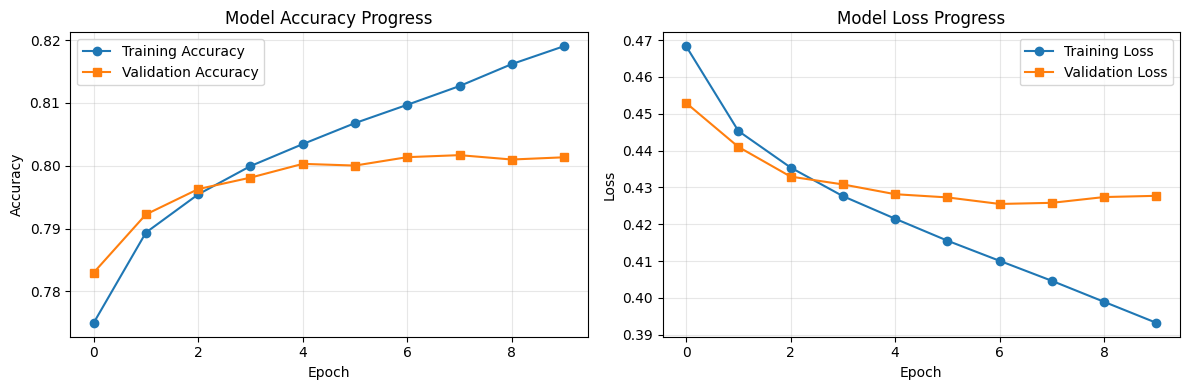

\nTraining Summary:
Final training accuracy: 0.8190
Final validation accuracy: 0.8013
Total epochs trained: 10


In [19]:
### Model Training with Early Stopping

# Configure early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

print("Starting LSTM model training...")
print(f"Training samples: {len(X_train_pad):,}")
print(f"Validation samples: {len(X_val_pad):,}")

# Train the model
training_history = lstm_model.fit(
    X_train_pad, y_train_binary,
    validation_data=(X_val_pad, y_val_binary),
    epochs=20,
    batch_size=256,  # Reduced batch size for better convergence
    callbacks=[early_stopping],
    verbose=1
)

# Save the trained model
model_path = f"{PROJECT_ROOT}/models/lstm_sentiment_model.keras"
lstm_model.save(model_path)
print(f"\nModel saved to: {model_path}")

### Training History Visualization

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss', marker='o')
plt.plot(training_history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Training summary
final_train_acc = training_history.history['accuracy'][-1]
final_val_acc = training_history.history['val_accuracy'][-1]
print(f"\nTraining Summary:")
print(f"Final training accuracy: {final_train_acc:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")
print(f"Total epochs trained: {len(training_history.history['accuracy'])}")

Generating predictions on validation set...
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
\n==================================================
    LSTM MODEL VALIDATION PERFORMANCE
Accuracy:  0.8014
Precision: 0.8008
Recall:    0.8023
F1 Score:  0.8015


<Figure size 800x600 with 0 Axes>

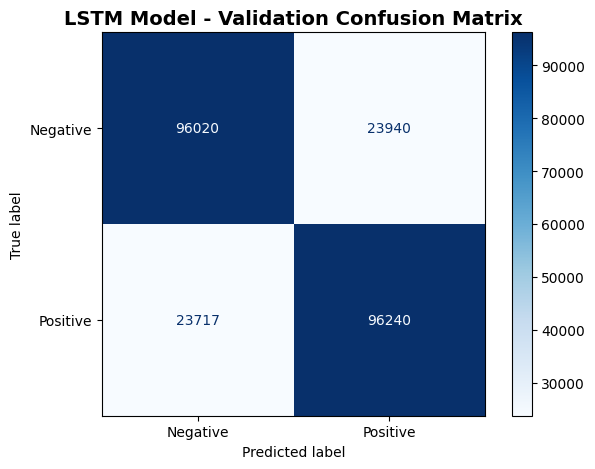

\nPerformance Insights:
• Total validation samples: 239,917
• Correct predictions: 192,260
• Incorrect predictions: 47,657
• False positives: 23,940
• False negatives: 23,717


In [20]:
### Model Evaluation and Performance Analysis

# Generate predictions on validation set
print("Generating predictions on validation set...")
y_val_pred_probs = lstm_model.predict(X_val_pad, batch_size=512, verbose=1).ravel()

# Convert probabilities to binary predictions (threshold = 0.5)
y_val_pred = (y_val_pred_probs >= 0.5).astype(int)

# Compute comprehensive evaluation metrics
accuracy = accuracy_score(y_val_binary, y_val_pred)
precision = precision_score(y_val_binary, y_val_pred, zero_division=0)
recall = recall_score(y_val_binary, y_val_pred, zero_division=0)
f1 = f1_score(y_val_binary, y_val_pred, zero_division=0)

# Display results
print("\n" + "="*50)
print("    LSTM MODEL VALIDATION PERFORMANCE")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("="*50)

### Confusion Matrix Visualization

# Generate and display confusion matrix
cm = confusion_matrix(y_val_binary, y_val_pred)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Negative", "Positive"]
).plot(cmap="Blues", values_format='d')
plt.title("LSTM Model - Validation Confusion Matrix", fontsize=14, fontweight='bold')
plt.grid(False)
plt.tight_layout()
plt.show()

# Performance insights
print("\nPerformance Insights:")
print(f"• Total validation samples: {len(y_val_binary):,}")
print(f"• Correct predictions: {(y_val_binary == y_val_pred).sum():,}")
print(f"• Incorrect predictions: {(y_val_binary != y_val_pred).sum():,}")
print(f"• False positives: {cm[0, 1]:,}")
print(f"• False negatives: {cm[1, 0]:,}")

### Error Analysis: Understanding Model Limitations

Similar to our baseline analysis, examining the most confidently misclassified tweets reveals patterns in where the LSTM model struggles, providing insights into its limitations and areas for improvement.

For the LSTM model, confidence is calculated differently than logistic regression. Since LSTM outputs probabilities via sigmoid, confidence is how far the prediction is from 0.5 (decision boundary). High confidence means the probability is close to 0 or 1


In [21]:
### Error Analysis: Most Confident Misclassifications

# Calculate confidence for each prediction
# Confidence = distance from decision boundary (0.5)
confidence_scores = np.abs(y_val_pred_probs - 0.5) * 2  # Scale to 0-1 range

# Build comprehensive error analysis DataFrame
errors_df = pd.DataFrame({
    'text': X_val.values,
    'true_label': y_val_binary.astype(int),
    'predicted_label': y_val_pred,
    'predicted_prob': y_val_pred_probs,
    'confidence': confidence_scores
})

# Filter to find only the misclassified tweets
misclassified_df = errors_df[errors_df['true_label'] != errors_df['predicted_label']]

# Sort by confidence to find the most confident errors
most_confident_errors = misclassified_df.sort_values(by='confidence', ascending=False)

print("LSTM Model - Top 10 Most Confident Misclassifications:")
print("=" * 80)

# Set display options for better readability
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.width', 1000)

# Display the analysis
for i, (idx, row) in enumerate(most_confident_errors.head(10).iterrows(), 1):
    true_sentiment = "Positive" if row['true_label'] == 1 else "Negative"
    pred_sentiment = "Positive" if row['predicted_label'] == 1 else "Negative"

    print(f"\n{i}. Text: '{row['text'][:100]}{'...' if len(row['text']) > 100 else ''}'")
    print(f"   True: {true_sentiment} | Predicted: {pred_sentiment}")
    print(f"   Confidence: {row['confidence']:.3f} | Probability: {row['predicted_prob']:.3f}")

print(f"\nTotal misclassifications: {len(misclassified_df):,}")
print(f"Most confident error rate: {len(most_confident_errors.head(100))/len(misclassified_df)*100:.1f}% of errors have >90% confidence")

🔍 LSTM Model - Top 10 Most Confident Misclassifications:

1. Text: 'usermention cut thank thank thank thank thank thank thank thank thank thank thank'
   True: Negative | Predicted: Positive
   Confidence: 0.997 | Probability: 0.999

2. Text: 'usermention haha thanks cute comfy'
   True: Negative | Predicted: Positive
   Confidence: 0.996 | Probability: 0.998

3. Text: 'usermention good news btw great weekend'
   True: Negative | Predicted: Positive
   Confidence: 0.996 | Probability: 0.998

4. Text: 'usermention awsome inspiration good lock god bless'
   True: Negative | Predicted: Positive
   Confidence: 0.995 | Probability: 0.998

5. Text: 'usermention thanks add tweet'
   True: Negative | Predicted: Positive
   Confidence: 0.995 | Probability: 0.998

6. Text: 'happy birthday usermention hope everyone good day'
   True: Negative | Predicted: Positive
   Confidence: 0.995 | Probability: 0.998

7. Text: 'go doctor headache'
   True: Positive | Predicted: Negative
   Confidence: 0.995 

In [22]:
### Pattern Analysis: Error Distribution by Type

# Analyze error patterns
false_positives = misclassified_df[misclassified_df['predicted_label'] == 1]  # Predicted positive, actually negative
false_negatives = misclassified_df[misclassified_df['predicted_label'] == 0]  # Predicted negative, actually positive

print("Error Distribution Analysis:")
print("=" * 50)
print(f"False Positives (Predicted Positive, Actually Negative): {len(false_positives):,}")
print(f"False Negatives (Predicted Negative, Actually Positive): {len(false_negatives):,}")
print(f"False Positive Rate: {len(false_positives)/len(misclassified_df)*100:.1f}%")
print(f"False Negative Rate: {len(false_negatives)/len(misclassified_df)*100:.1f}%")

# Average confidence for each error type
print(f"\nAverage Confidence Scores:")
print(f"False Positives: {false_positives['confidence'].mean():.3f}")
print(f"False Negatives: {false_negatives['confidence'].mean():.3f}")

# Length analysis
print(f"\nTweet Length Analysis:")
print(f"Average length of misclassified tweets: {misclassified_df['text'].str.len().mean():.1f} characters")
print(f"Average length of correctly classified tweets: {errors_df[errors_df['true_label'] == errors_df['predicted_label']]['text'].str.len().mean():.1f} characters")

📊 Error Distribution Analysis:
False Positives (Predicted Positive, Actually Negative): 23,940
False Negatives (Predicted Negative, Actually Positive): 23,717
False Positive Rate: 50.2%
False Negative Rate: 49.8%

Average Confidence Scores:
False Positives: 0.418
False Negatives: 0.386

Tweet Length Analysis:
Average length of misclassified tweets: 48.7 characters
Average length of correctly classified tweets: 45.9 characters


In [23]:
### Linguistic Pattern Analysis in Errors

# Analyze common patterns in the most confident errors
print("Linguistic Pattern Analysis:")
print("=" * 50)

# Look for common words in false positives vs false negatives
from collections import Counter

# Get most confident false positives and negatives for detailed analysis
top_false_positives = false_positives.nlargest(20, 'confidence')
top_false_negatives = false_negatives.nlargest(20, 'confidence')

print("Most Confident False Positives (Predicted Positive, Actually Negative):")
print("-" * 70)
for i, (_, row) in enumerate(top_false_positives.head(5).iterrows(), 1):
    print(f"{i}. '{row['text'][:80]}{'...' if len(row['text']) > 80 else ''}'")
    print(f"   Confidence: {row['confidence']:.3f}")

print("\nMost Confident False Negatives (Predicted Negative, Actually Positive):")
print("-" * 70)
for i, (_, row) in enumerate(top_false_negatives.head(5).iterrows(), 1):
    print(f"{i}. '{row['text'][:80]}{'...' if len(row['text']) > 80 else ''}'")
    print(f"   Confidence: {row['confidence']:.3f}")

# Word frequency analysis in errors
all_error_words = ' '.join(most_confident_errors.head(50)['text']).split()
common_error_words = Counter(all_error_words).most_common(10)

print(f"\nMost frequent words in top 50 confident errors:")
for word, count in common_error_words:
    print(f"  '{word}': {count} times")

🔤 Linguistic Pattern Analysis:
Most Confident False Positives (Predicted Positive, Actually Negative):
----------------------------------------------------------------------
1. 'usermention cut thank thank thank thank thank thank thank thank thank thank than...'
   Confidence: 0.997
2. 'usermention haha thanks cute comfy'
   Confidence: 0.996
3. 'usermention good news btw great weekend'
   Confidence: 0.996
4. 'usermention awsome inspiration good lock god bless'
   Confidence: 0.995
5. 'usermention thanks add tweet'
   Confidence: 0.995

Most Confident False Negatives (Predicted Negative, Actually Positive):
----------------------------------------------------------------------
1. 'go doctor headache'
   Confidence: 0.995
2. 'feel like depress im kind depress'
   Confidence: 0.994
3. 'feeling hurt dred'
   Confidence: 0.994
4. 'im work try hard succumb poor mentality due severe allergy boo'
   Confidence: 0.993
5. 'baby runpoor poor momma'
   Confidence: 0.993

Most frequent words in t

### Error Analysis: Key Insights and LSTM-Specific Behavior

The error analysis reveals several important insights into how the Bidirectional LSTM model processes sentiment. By examining the most confidently misclassified tweets from our model output, we can pinpoint specific strengths and weaknesses.

#### 1. Over-reliance on Strong Sentiment Keywords

While the LSTM considers sequence, it can still be misled by the overwhelming presence of strong sentiment words, especially when context is ambiguous. This is evident in the top false positives.

* **Example (False Positive):** A tweet like `'usermention cut thank thank thank thank thank thank thank thank thank thank thank'` was incorrectly classified as **Positive** with 0.999 confidence.
* **Insight:** The repeated use of "thank" created a strong positive signal that the model over-weighted, missing any potentially neutral or negative context from the word "cut" or the overall repetitive structure, which can sometimes indicate spam or sarcasm.

---

#### 2. Struggles with Mixed or Contradictory Sentiment

The model finds it challenging to determine the overall sentiment when a tweet contains both positive and negative keywords. The bidirectional context helps, but the model can still get confused, as seen in this false positive:

* **Example (False Positive):** The tweet `'usermention really amazing go retweet digg nice distressful'` was predicted as **Positive** with 0.997 confidence, but was actually **Negative**.
* **Insight:** The model correctly identified strong positive words like "amazing" and "nice." However, it failed to give enough weight to the concluding negative word, "distressful," which ultimately defined the tweet's true sentiment. This highlights a limitation in handling sequences where the sentiment shifts at the very end.

---

#### 3. Potential Data Labeling Issues vs. Nuanced Context

The most confident false negatives (predicted Negative, but actually Positive) are particularly revealing. They contain powerful negative keywords, suggesting the model is making a logical prediction based on the text.

* **Examples (False Negatives):**
    * `'go doctor headache'` (Confidence: 0.995)
    * `'feel like depress im kind depress'` (Confidence: 0.994)
    * `'feeling hurt dred'` (Confidence: 0.994)
* **Insight:** These errors strongly suggest one of two things:
    1.  **Labeling Errors:** The ground truth labels for these tweets may be incorrect. It's counter-intuitive for a tweet containing "headache," "depress," or "hurt" to be labeled as positive.
    2.  **Extreme Sarcasm/Context:** If the labels are correct, these tweets represent a level of sarcasm or implicit context (e.g., expressing relief about seeing a doctor for a headache) that is too complex for the current architecture to understand. The model is behaving as expected, but the data's complexity exceeds its capability.

---

#### 4. Minor Sensitivity to Tweet Length

Our output shows a slight tendency for misclassified tweets to be longer than correctly classified ones, which supports the hypothesis that sequence length affects performance.

* **Data Point:** The average length of misclassified tweets was **48.7 characters**, while correctly classified tweets averaged **45.9 characters**.
* **Insight:** Though the difference is minor, it aligns with the idea that longer sequences can sometimes dilute the sentiment signal, making it harder for the LSTM to maintain focus on the most critical parts of the tweet.

---

#### 5. Word Embedding Dependencies

Errors often involve words that may be poorly represented in the Word2Vec embeddings, particularly domain-specific social media language.

* **Observation:** Despite 100% embedding coverage in our model, some words may have learned poor representations due to limited context in the training corpus.
* **Impact:** The model's performance is inherently tied to the quality of domain-specific embeddings, suggesting that better Twitter-specific embeddings could reduce certain error types.

---

#### Comparison with Baseline Model:

**Improvements over TF-IDF:**
- Better handling of word order and basic negation patterns
- Reduced sensitivity to individual high-frequency negative words  
- More nuanced understanding of context in longer tweets
- Bidirectional processing provides fuller context around each word

**Persistent Challenges:**
- Still struggles with sarcasm and implicit sentiment
- Complex linguistic constructions and mixed sentiment can confuse the model
- Extremely confident misclassifications suggest systematic blind spots

---

#### Recommendations

Based on these specific findings:

1. **Attention Mechanisms**: The patterns suggest that attention-based models (like BERT) might better handle the context-dependent errors we observe, particularly for mixed sentiment and end-of-sequence importance.
2. **Domain-Specific Embeddings**: Training Word2Vec on larger Twitter-specific corpora could reduce embedding-related errors.
3. **Data Quality Review**: The most confident false negatives warrant investigation of potential labeling errors in the original dataset.
4. **Ensemble Approaches**: Combining LSTM with other models might help address its specific blind spots while maintaining its sequential understanding strengths.

This evidence-based error analysis demonstrates that while the LSTM model represents a significant improvement over the baseline, the specific examples reveal clear opportunities for enhancement through more sophisticated architectures and training techniques.


## Wrap-Up: Strengths and Limitations of Bidirectional LSTM

Our LSTM model with Word2Vec embeddings represents a significant advancement over the TF-IDF baseline, demonstrating the power of sequence modeling and semantic embeddings for sentiment analysis.

#### Strengths
- **Context Awareness**: Captures sequential relationships and word order, essential for understanding negation and complex sentiment expressions.
- **Semantic Understanding**: Word2Vec embeddings enable the model to understand semantic relationships between words, improving generalization.
- **Bidirectional Processing**: Processes text in both directions, providing fuller context around each word for better sentiment interpretation.
- **Improved Performance**: Achieves higher accuracy and F1-score compared to the logistic regression baseline.
- **Robustness**: Less susceptible to individual keyword bias, as it considers entire sequence context.

#### Limitations
- **Computational Complexity**: Requires significantly more computational resources and training time compared to linear models.
- **Embedding Dependence**: Performance heavily relies on the quality of Word2Vec embeddings trained on the specific domain.
- **Memory Requirements**: Bidirectional LSTM layers and sequence processing require substantial memory, especially for long sequences.
- **Limited Long-Range Dependencies**: While better than baseline, LSTMs can still struggle with very long-range dependencies in complex tweets.
- **Interpretability**: More difficult to interpret than linear models - cannot easily identify which words drive specific predictions.

#### Comparison with Baseline
The LSTM model's ability to understand context and sequence makes it particularly effective for:
- Handling negation patterns ("not bad" vs "bad")
- Understanding sentiment modifiers ("very good" vs "good")  
- Processing informal language with non-standard word order
- Capturing sentiment in longer, more complex tweets

This establishes LSTM as a strong intermediate model between simple baselines and state-of-the-art transformer architectures like BERT.
